<h1> Lab 3

In [3]:
#Basic packages
import numpy as np
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
import warnings     #Supress warnings
warnings.filterwarnings("ignore")
#sklearn basics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.inspection import permutation_importance
#GP imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
#other clasical regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
#for Bayesian plotting
from scipy.stats import norm
#handy function to return RMSE
def root_mean_squared_error(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

<h3> Exercise Set 1: Bayesian Updating

Our prior is:
$$
    p(\theta) = \frac 1 {\tau_0\sqrt{2\pi}}e^{-\frac {(\theta-\theta_0)^2} {2\tau_0^2}}
$$

Our single-draw likelihood is:
$$
    p(x_i|\theta) = \frac 1 {\sigma\sqrt{2\pi}}e^{-\frac {(x_i-\theta)^2} {2\sigma^2}}
$$

So our likelihood function is:
$$
    p(x|\theta) = \prod_{i\leq n}p(x_i|\theta) = \left(\frac 1 {\sigma\sqrt{2\pi}}\right)^ne^{-\frac 1 {2\sigma^2}\sum_{i}(x_i-\theta)^2}
$$

By Bayes' Theorem this implies our posterior is:
$$
    p(\theta|x) = \frac 1 {\tau_0\sqrt{2\pi}}e^{-\frac {(\theta-\theta_0)^2} {2\tau_0^2}}\left(\frac 1 {\sigma\sqrt{2\pi}}\right)^ne^{-\frac 1 {2\sigma^2}\sum_{i}(x_i-\theta)^2}
$$

let: 
$$
    \tau_n^2 = \left(\frac n {\sigma^2} + \frac 1 {\tau_0^2}\right)^{-1}
$$
then our posterior can be rewritten as:
$$
    p(\theta|x) = \frac 1 {\tau_n\sqrt{2\pi}} e^{-\frac {(\theta-\theta_n)^2} {2\tau_n^2}}
$$
where: 
$$
    \theta_n = \tau_n^2 \left(\frac n {\sigma^2}\left(\frac 1 n\sum_{i}x_i\right) + \frac {\theta_0} {\tau_0^2}\right)
$$

Given real data $ x = \{2,3,4\}, \theta_0 = 0, \tau_0^2 = 1, \sigma^2 = 1 $
$$
    \tau_n^2 = \left(\frac 3 1 + \frac 1 1\right)^{-1} = \frac 1 4
$$
and
$$
    \theta_n = \frac 1 4 \left(\frac 3 1\left(\frac 1 3(2+3+4)\right) + 0\right) = \frac 9 4

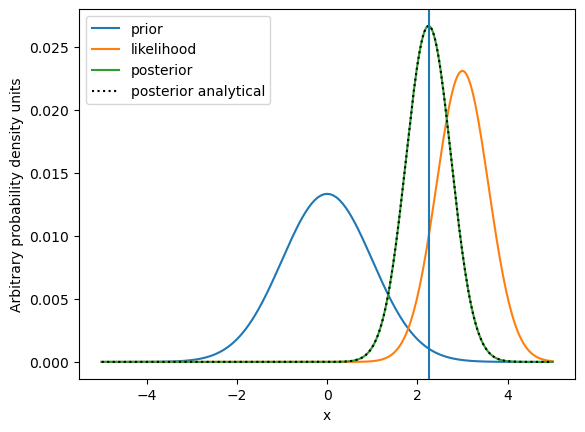

In [59]:
# Exercise Set 1 (c)

# Define some helpful functions
def normProbDensity(mu, sig, x):
    return 1/(sig * np.sqrt(2 * np.pi)) * np.exp(-(x-mu)**2 / (2 * sig**2))

def scaleProb(x):
    scaler = 1 / np.sum(x)
    return x * scaler

# get prior graph
x = np.linspace(-5,5,300)
prior = normProbDensity(0, 1, x)

# get likelihood graph numerically
draws = [2,3,4]
likelihood = np.ones(x.size)
for i in draws:
    likelihood = likelihood * normProbDensity(np.mean(draws), 1, x)

# get posterior graph using bayes theorem
posterior = likelihood * prior

# scale probability densities for graphing
prior = scaleProb(prior)
likelihood = scaleProb(likelihood)
posterior = scaleProb(posterior)

# get posterior graph from analytical solution of bayes theorem
posterior2 = normProbDensity(9/4, 1/2, x)
posterior2 = scaleProb(posterior2)

# plot all distributions
plt.plot(x, prior, label='prior')
plt.plot(x, likelihood, label='likelihood')
plt.plot(x, posterior, label='posterior')
plt.plot(x, posterior2, label='posterior analytical', linestyle='dotted', color='black')
plt.axvline(9/4)
plt.ylabel('Arbitrary probability density units')
plt.xlabel('x')
plt.legend()
plt.show()

<h3> Exercise Set 2: Data Preparation

In [69]:
# Exercise Set 2 (a)
url='https://raw.githubusercontent.com/aims-umich/ners590data/main/sparc.csv'
data = pd.read_csv(url)
print(data.head(5))
colnames = data.columns
X = data.values[:,0:6]
Y = data.values[:,6:8]

   Magnetic  PlasmaCurrent  Elongation  Triangularity  Beta  Density       W  \
0      11.5           4.00        1.82           0.49  1.55     15.0  0.0472   
1      11.5           6.50        1.82           0.49  1.30     15.0  0.0350   
2      11.5           5.25        1.89           0.43  0.80     15.0  0.0384   
3      11.5           9.00        1.96           0.37  1.55     15.0  0.0264   
4      11.5           5.25        1.96           0.37  1.55     15.0  0.0369   

        T  
0  3498.5  
1  4988.3  
2  3699.9  
3  4961.6  
4  3335.5  


In [70]:
# Exercise Set 2 (b)
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.45, random_state=42)

In [72]:
# Exercise Set 2 (c)
xscaler = MinMaxScaler()
Xtrain = xscaler.fit_transform(xtrain)
Xtest = xscaler.transform(xtest)

yscaler = StandardScaler()
Ytrain = yscaler.fit_transform(ytrain)
Ytest = yscaler.transform(ytest)

<h3> Exercise Set 3: Non-linear Regression

In [112]:
# Exercise Set 3 (a)
dt = DecisionTreeRegressor(min_samples_split=3)
dt.fit(Xtrain, Ytrain)
Ydt=dt.predict(Xtest)

# Exercise Set 3 (b)
rf = RandomForestRegressor(n_estimators=200)
rf.fit(Xtrain, Ytrain)
Yrf=rf.predict(Xtest)

# Exercise Set 3 (c)
gb = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=300))
gb.fit(Xtrain, Ytrain)
Ygb=gb.predict(Xtest)

# Exercise Set 3 (d)

#Define a composite kernel
k = ConstantKernel(constant_value=1) + \
WhiteKernel(noise_level=1) + \
Matern(length_scale=1, nu=1.5)

gp = GaussianProcessRegressor(kernel=k)
gp.fit(Xtrain, Ytrain)
Ygp, Ygpstd=gp.predict(Xtest, return_std=True)

# Exercise Set 3 (e)
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
Ylr=lr.predict(Xtest)

In [110]:
# Exercise Set 3 (f)
def metrics(true, predict):
    return mean_absolute_error(true, predict), mean_absolute_percentage_error(true, predict), r2_score(true, predict), root_mean_squared_error(true, predict)

metdf = pd.DataFrame(np.column_stack((metrics(Ytest, Ydt), metrics(Ytest, Yrf), metrics(Ytest, Ygb), \
                    metrics(Ytest, Ygp), metrics(Ytest, Ylr))), index=['MAE', 'MAPE', 'R2', 'RMSE'], \
                    columns = ['Decision Tree', 'Random Forest', 'Gradient Boosting', \
                               'Gaussian Process', 'Linear Regression'])

print(metdf)

      Decision Tree  Random Forest  Gradient Boosting  Gaussian Process  \
MAE        0.094427       0.079343           0.163148          0.139523   
MAPE       0.992053       0.831198           1.184095          1.247132   
R2         0.939371       0.960260           0.894407          0.925294   
RMSE       0.217065       0.174027           0.276157          0.234489   

      Linear Regression  
MAE            0.323273  
MAPE           2.401699  
R2             0.684505  
RMSE           0.481224  


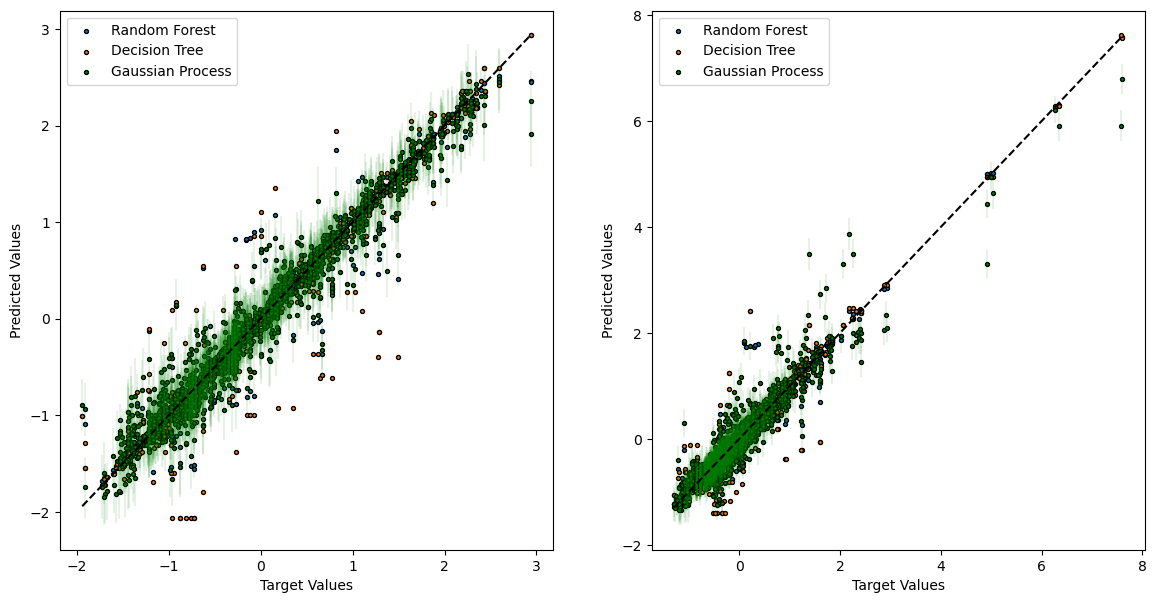

In [129]:
fig, ax = plt.subplots(1,2, figsize=(14,7))
for i in [0,1]:
    ax[i].scatter(Ytest[:,i], Yrf[:,i], label="Random Forest", edgecolor='black', s=8)
    ax[i].scatter(Ytest[:,i], Ydt[:,i], label="Decision Tree", edgecolor='black', s=8)
    ax[i].scatter(Ytest[:,i], Ygp[:,i], label="Gaussian Process", s=8, color='g', edgecolor='black')
    ax[i].errorbar(Ytest[:,i], Ygp[:,i], yerr=Ygpstd[:,i], fmt="o", color='g', alpha=0.1, markersize=0)
    ax[i].legend()
    ax[i].set_xlabel("Target Values")
    ax[i].set_ylabel("Predicted Values")
    ax[i].plot([min(Ytest[:,i]), max(Ytest[:,i])], [min(Ytest[:,i]), max(Ytest[:,i])], color='black', linestyle='--')

plt.show()